In [344]:
import numpy as np
import h5py
from scipy.io import loadmat
import re
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy
import warnings
from scipy.ndimage import median_filter, gaussian_filter

# import Python functions 
import sys
sys.path.append('./Python_Functions')

from Python_Functions.functions import cropProfmonImg, matstruct_to_dict, extractDAQBSAScalars, segment_centroids_and_com, plot2DbunchseparationVsCollimatorAndBLEN

In [345]:
# Define XTCAV calibration
krf = 239.26
cal = 1167 # um/deg  http://physics-elog.slac.stanford.edu/facetelog/show.jsp?dir=/2025/11/13.03&pos=2025-$
streakFromGUI = cal*krf*180/np.pi*1e-6#um/um

# Sets the main beam energy
mainbeamE_eV = 10e9
# Sets the dnom value for CHER
dnom = 59.8e-3

In [346]:
# Sets data location
experiment = 'E338'
runname = '12710'

### Load dataset

In [347]:
# Loads dataset
dataloc = 'data/' + experiment + '/' + experiment + '_' + runname + '/' + experiment + '_'  +runname + '.mat'
mat = loadmat(dataloc,struct_as_record=False, squeeze_me=True)
data_struct = mat['data_struct']

# Extracts number of steps
stepsAll = data_struct.params.stepsAll
if stepsAll is None or len(np.atleast_1d(stepsAll)) == 0:
    stepsAll = 1

# calculate xt calibration factor
xtcalibrationfactor = data_struct.metadata.DTOTR2.RESOLUTION*1e-6/streakFromGUI/3e8

# cropping aspect ratio 
xrange = 100 
yrange = xrange


# gaussian filter parameter
sigma = 5

In [487]:
xtcavImages_list = []
horz_proj_list = []

for a in range(len(stepsAll)):
    raw_path = data_struct.images.DTOTR2.loc[a]
    match = re.search(rf'({experiment}_\d+/images/DTOTR2/DTOTR2_data_step\d+\.h5)', raw_path)
    if not match:
        raise ValueError(f"Path format invalid or not matched: {raw_path}")

    DTOTR2datalocation = 'data/'+ experiment + '/' + match.group(0)

    with h5py.File(DTOTR2datalocation, 'r') as f:
        data_raw = f['entry']['data']['data'][:].astype(np.float64)  # shape: (N, H, W)
    
    # Transpose to shape: (H, W, N)
    DTOTR2data_step = np.transpose(data_raw, (2, 1, 0))
    xtcavImages_step = DTOTR2data_step - data_struct.backgrounds.DTOTR2[:,:,np.newaxis].astype(np.float64)
    
    for idx in range(DTOTR2data_step.shape[2]):
        if idx is None:
            continue
        image = xtcavImages_step[:,:,idx]
        
        # crop images 
        image_cropped, _ = cropProfmonImg(image, xrange, yrange, plot_flag=False)
        Nrows = np.array(image_cropped).shape[0]
        img = median_filter(image_cropped, size=10)
        processed_image = gaussian_filter(img, sigma=sigma, truncate = 6)
        [centroidIndices, centers_of_mass] = segment_centroids_and_com(processed_image, Nrows,1)

        # centroid correcion
        centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
        centroid_corrections[np.isnan(centroid_corrections)] = 0

        # shift images
        image_shifted = np.empty_like(image_cropped)
        for row in range(image_cropped.shape[0]):
            shift = int(-centroid_corrections[row])
            image_shifted[row] = np.roll(image_cropped[row], shift)
        # calcualte current profiles 
        horz_proj_idx = np.sum(image_cropped, axis=0)
        horz_proj_idx = horz_proj_idx[:,np.newaxis]
        image_shifted = image_shifted[:, :, np.newaxis]
        
        # combine current profiles into one array 
        horz_proj_list.append(horz_proj_idx)

        # combine images into one array 
        xtcavImages_list.append(image_shifted)

xtcavImages = np.concatenate(xtcavImages_list, axis=2)
horz_proj = np.concatenate(horz_proj_list, axis=1)

# Keeps only the data with a common index
DTOTR2commonind = data_struct.images.DTOTR2.common_index -1 
horz_proj = horz_proj[:,DTOTR2commonind]
xtcavImages = xtcavImages[:,:,DTOTR2commonind]

In [488]:
bsaScalarData, bsaVars = extractDAQBSAScalars(data_struct)

ampl_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_A' in var)
xtcavAmpl = bsaScalarData[ampl_idx, :]

phase_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_P' in var)
xtcavPhase = bsaScalarData[phase_idx, :]

xtcavOffShots = xtcavAmpl<0.1
xtcavPhase[xtcavOffShots] = 0 #Set this for ease of plotting

plot_titles = ['Tcav phase -90 deg', '0 deg', '+90 deg']

### Calculate the current profile normalizing the integral to the charge

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_4499/2057964118.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)
/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_4499/2057964118.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)


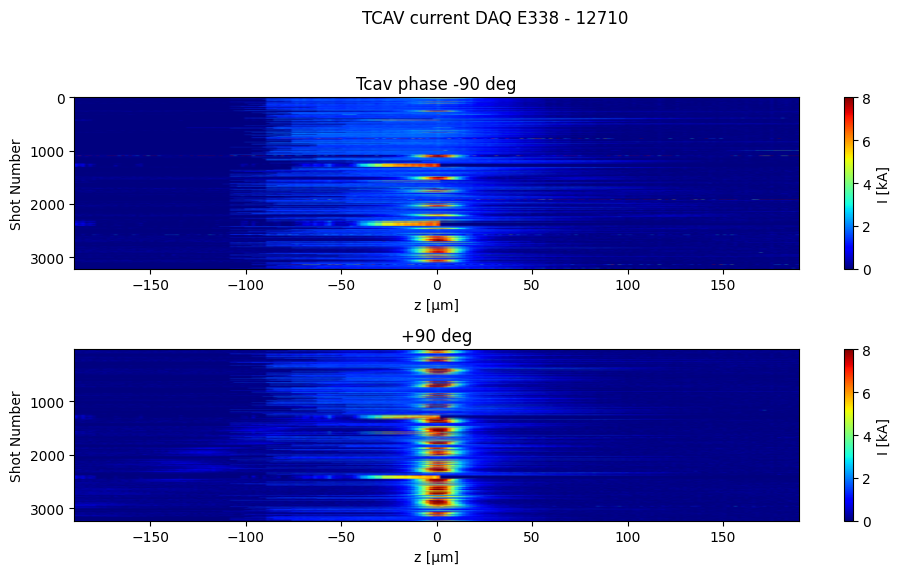

In [489]:
isChargePV = [bool(re.search(r'TORO_LI20_2452_TMIT', pv)) for pv in bsaVars]
pvidx = [i for i, val in enumerate(isChargePV) if val]
charge = bsaScalarData[pvidx, :] * 1.6e-19  # in C 

minus_90_idx = np.where((xtcavPhase >= -91) & (xtcavPhase <= -89))[0]
plus_90_idx = np.where((xtcavPhase >= 89) & (xtcavPhase <= 91))[0]

currentProfile_minus_90 = []
currentProfile_plus_90 = []

# Process -90 degree shots
for ij in range(len(minus_90_idx)):
    idx = minus_90_idx[ij]
    streakedProfile = horz_proj[:,idx]

    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero

    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)

    currentProfile = 1e-3 * streakedProfile * prefactor  # Convert to kA
    currentProfile_minus_90.append(currentProfile)

# Process +90 degree shots
for ij in range(len(plus_90_idx)):
    idx = plus_90_idx[ij]
    streakedProfile = horz_proj[:,idx]

    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero

    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)

    currentProfile = 1e-3 * streakedProfile * prefactor  # Convert to kA
    currentProfile_plus_90.append(currentProfile)

# Convert lists to arrays for plotting
currentProfile_minus_90 = np.array(currentProfile_minus_90)
currentProfile_plus_90 = np.array(currentProfile_plus_90)

# Plot
plt.figure(figsize=(10, 6))

# Subplot for -90°
plt.subplot(2, 1, 1)
extent_x = tvar * 3e8 * 1e6  # Convert to microns
plt.imshow(currentProfile_minus_90, aspect='auto', cmap='jet', vmin=0, vmax=8, extent=[extent_x[0], extent_x[-1], minus_90_idx[-1], minus_90_idx[0]])
plt.xlabel('z [μm]')
plt.ylabel('Shot Number')
plt.title(plot_titles[0])
plt.colorbar(label='I [kA]')

# Subplot for +90°
plt.subplot(2, 1, 2)
plt.imshow(currentProfile_plus_90, aspect='auto', cmap='jet', vmin=0, vmax=8, extent=[extent_x[0], extent_x[-1], plus_90_idx[-1], plus_90_idx[0]])
plt.xlabel('z [μm]')
plt.ylabel('Shot Number')
plt.title(plot_titles[2])
plt.colorbar(label='I [kA]')

plt.suptitle(f"TCAV current DAQ {experiment} - {runname}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [490]:
ispv = [bool(re.search(r'BLEN_LI14_888_BRAW', pv)) for pv in bsaVars]
pvidx = [i for i, val in enumerate(ispv) if val]

bc14BLEN = bsaScalarData[pvidx,:]
separationCutoff = 0.05

### Calculate bunch separation using *find_peaks*

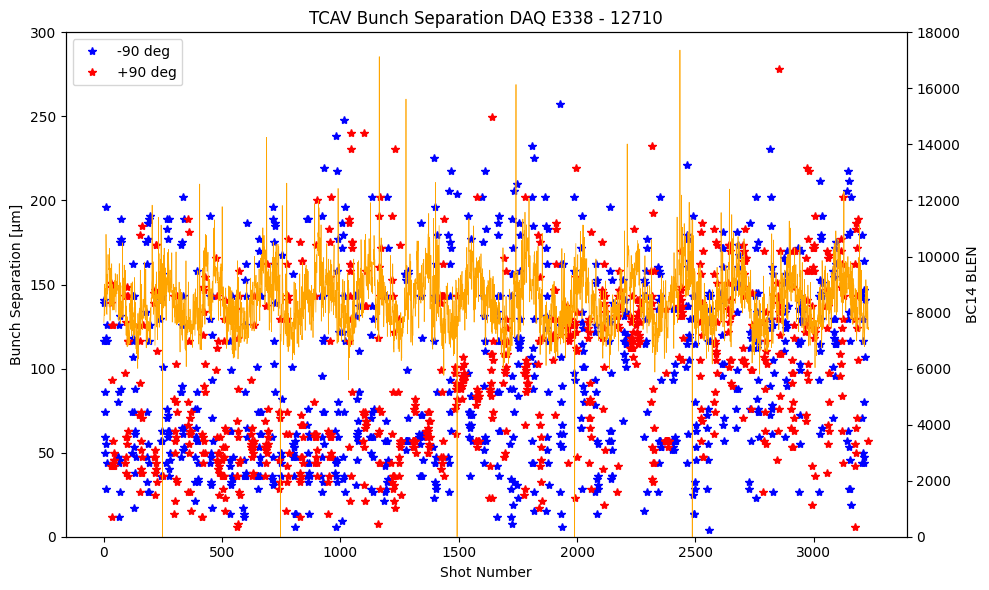

In [491]:
from scipy.signal import find_peaks, peak_prominences

all_idx = np.concatenate((minus_90_idx, plus_90_idx), axis = 0)
bunchSeparation_plus_90 = []
bunchSeparation_minus_90 = []

for ij in range(len(plus_90_idx)):
    profile = currentProfile_plus_90[ij, :] 
    peaks, _ = find_peaks(profile)
    prominences = peak_prominences(profile, peaks)[0]
    if len(prominences) < 2:
        bunchSeparation_plus_90.append(0)
        continue
    
    top2_indices = np.argsort(prominences)[-2:]
    pos = peaks[top2_indices]

    peak_separation = abs(pos[0] - pos[1])

    if abs(prominences[top2_indices[0]]) * separationCutoff > abs(prominences[top2_indices[1]]):
        peak_separation = 0

    bunchSeparation_plus_90.append(peak_separation * xtcalibrationfactor)

for ij in range(len(minus_90_idx)):
    profile = currentProfile_minus_90[ij, :] 
    peaks, _ = find_peaks(profile)
    prominences = peak_prominences(profile, peaks)[0]
    if len(prominences) < 2:
        bunchSeparation_minus_90.append(0)
        continue
    
    top2_indices = np.argsort(prominences)[-2:]
    pos = peaks[top2_indices]

    peak_separation = abs(pos[0] - pos[1])

    if abs(prominences[top2_indices[0]]) * separationCutoff > abs(prominences[top2_indices[1]]):
        peak_separation = 0

    bunchSeparation_minus_90.append(peak_separation * xtcalibrationfactor)

bunch_sep_plus_90_um = np.array(bunchSeparation_plus_90) * 3e8 * 1e6
bunch_sep_minus_90_um = np.array(bunchSeparation_minus_90) * 3e8 * 1e6

# Create figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot bunch separations
ln1 = ax1.plot(minus_90_idx, bunch_sep_minus_90_um, '*b', label='-90 deg')
ln2 = ax1.plot(plus_90_idx, bunch_sep_plus_90_um, '*r', label='+90 deg')

ax1.set_xlabel('Shot Number')
ax1.set_ylabel('Bunch Separation [μm]', color='black')
ax1.set_ylim(0, 300)  

# Create secondary y-axis for BC14 BLEN
ax2 = ax1.twinx()
shot_numbers = np.arange(bc14BLEN.shape[1])
ln3 = ax2.plot(shot_numbers,bc14BLEN[0], color = 'orange', linewidth=0.5)
ax2.set_ylabel('BC14 BLEN', color='black')
ax2.set_ylim(0, 18000)

# Combine legends
lines = ln1 + ln2 
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

# Title and appearance
plt.title(f'TCAV Bunch Separation DAQ {experiment} - {runname}')
# plt.xlim((-100,2100))
fig.tight_layout()
fig.patch.set_facecolor('white')

plt.show()

### Now fit a 2D function to the data an plot the surface

In [522]:
steps = data_struct.scalars.steps[DTOTR2commonind]

# Define the data
X = bc14BLEN[0][plus_90_idx[goodShots]]
Y = steps[plus_90_idx[goodShots]]
Z = bunchSeparation_plus_90_fit # in microns 

# # Filter good shots
# goodShots = np.where((Z < 250) & (Z > 0))
# X = X[goodShots]
# Y = Y[goodShots]
# Z = Z[goodShots]

x_min = 6000
x_max = 12000

# Create a mask for the subset
subset_mask = (X >= x_min) & (X <= x_max)

# Apply mask to all arrays
X = X[subset_mask]
Y = Y[subset_mask]
Z = Z[subset_mask]

# Combine X and Y into a matrix with two columns
XY = np.column_stack((X, Y))

# Fit a polynomial surface to the data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata
from sklearn.pipeline import make_pipeline

fit_deg = 2

model = make_pipeline(PolynomialFeatures(fit_deg), LinearRegression())
model.fit(XY, Z)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

### 3D Contour Plot

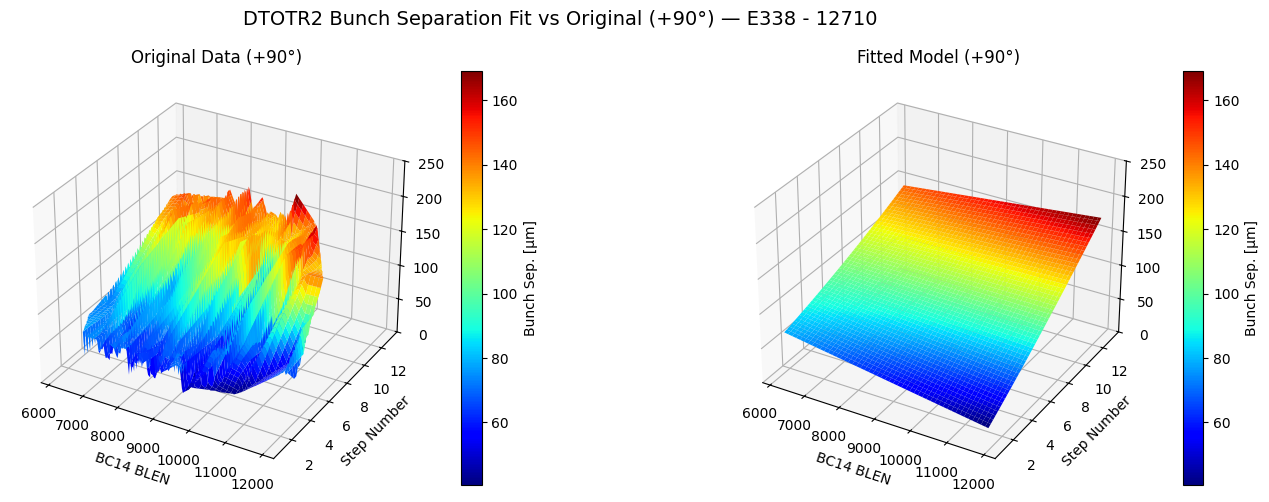

In [523]:
# Create a grid for plotting
N = 200
x = np.linspace(np.min(X), np.max(X), N)
y = np.linspace(np.min(Y), np.max(Y), N)
Xi, Yi = np.meshgrid(x, y)

# Evaluate the model on a grid
grid_points = np.vstack((Xi.ravel(), Yi.ravel())).T
Zi_fit = model.predict(grid_points).reshape(Xi.shape)
# Interpolate original Z data onto the grid
Zi_data = griddata((X, Y), Z, (Xi, Yi), method='linear')

# Create figure
fig = plt.figure(figsize=(15, 5))

# Plot original data
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(Xi, Yi, Zi_data, cmap='jet', edgecolor='none')
ax1.set_title('Original Data (+90°)')
ax1.set_xlabel('BC14 BLEN')
ax1.set_ylabel('Step Number')
fig.colorbar(surf1, ax=ax1, label='Bunch Sep. [μm]')
ax1.set_zlim(0, 250)

# Plot fitted model
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(Xi, Yi, Zi_fit, cmap='jet', edgecolor='none')
ax2.set_title('Fitted Model (+90°)')
ax2.set_xlabel('BC14 BLEN')
ax2.set_ylabel('Step Number')
fig.colorbar(surf1, ax=ax2, label='Bunch Sep. [μm]')
ax2.set_zlim(0, 250)

plt.suptitle(f'DTOTR2 Bunch Separation Fit vs Original (+90°) — {experiment} - {runname}', fontsize=14)
plt.tight_layout()
plt.show()

### 2D Projection Map

<Figure size 1500x500 with 0 Axes>

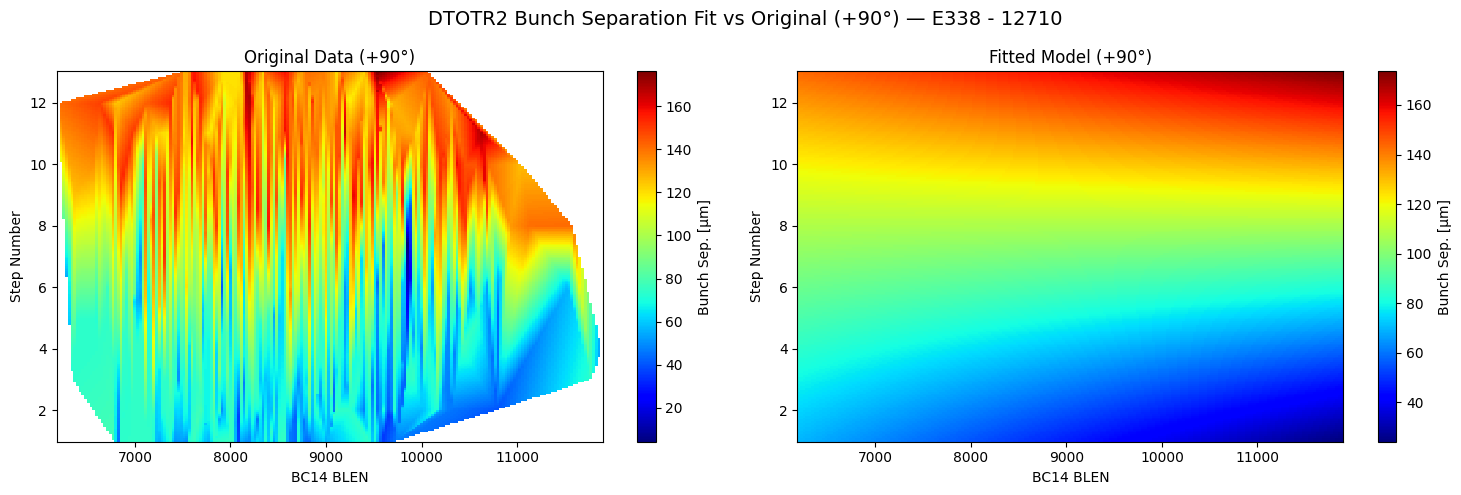

In [524]:
# Create a grid for plotting

N = 200
x = np.linspace(np.min(X), np.max(X), N)
y = np.linspace(np.min(Y), np.max(Y), N)
Xi, Yi = np.meshgrid(x, y)

# Evaluate the model on a grid
grid_points = np.vstack((Xi.ravel(), Yi.ravel())).T
Zi_fit = model.predict(grid_points).reshape(Xi.shape)
# Interpolate original Z data onto the grid
Zi_data = griddata((X, Y), Z, (Xi, Yi), method='linear')

# Create figure
fig = plt.figure(figsize=(15, 5))

# Plot original data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
c1 = ax1.pcolormesh(Xi, Yi, Zi_data, cmap='jet', shading='auto')
ax1.set_title('Original Data (+90°)')
ax1.set_xlabel('BC14 BLEN')
ax1.set_ylabel('Step Number')
fig.colorbar(c1, ax=ax1, label='Bunch Sep. [μm]')

# Plot fitted model
c2 = ax2.pcolormesh(Xi, Yi, Zi_fit, cmap='jet', shading='auto')
ax2.set_title('Fitted Model (+90°)')
ax2.set_xlabel('BC14 BLEN')
ax2.set_ylabel('Step Number')
fig.colorbar(c2, ax=ax2, label='Bunch Sep. [μm]')

plt.suptitle(f'DTOTR2 Bunch Separation Fit vs Original (+90°) — {experiment} - {runname}', fontsize=14)
plt.tight_layout()
plt.show()

### Bi-Gaussian Fit to Current Profiles

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_4499/2935078136.py:25: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)


Fit failed at index 544
Fit failed at index 565
Fit failed at index 566
Fit failed at index 658
Fit failed at index 695
Fit failed at index 703
Fit failed at index 758
Fit failed at index 762
Fit failed at index 766
Fit failed at index 813


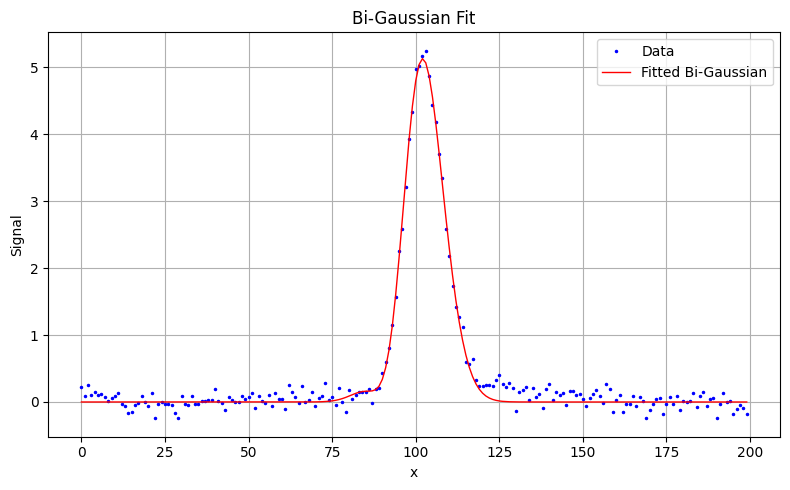

In [514]:
from scipy.optimize import curve_fit

# fit bi-Gaussian to +90 deg 

# Define the bi-Gaussian function
def bi_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) +
            A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

mean1 = []
mean2 = []
amp2 = [] 
sigma1 = []
sigma2 = []
R_squared = []

for ij in range(len(plus_90_idx)):
    y = currentProfile_plus_90[ij, :]
    x = np.arange(len(y))

    # Initial guess: [A1, mu1, sigma1, A2, mu2, sigma2]
    initial_guess = [np.max(y), 100, 4, np.max(y)*0.2, 50 + ij * 0.05, 4]

    try:
        popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)
    except RuntimeError:
        print(f"Fit failed at index {ij}")
        mean1.append(np.nan)
        mean2.append(np.nan)
        sigma1.append(np.nan)
        sigma2.append(np.nan)
        R_squared.append(np.nan)
        continue

    # Extract parameters
    A1, mu1_val, sig1, A2, mu2_val, sig2 = popt
    mean1.append(mu1_val)
    mean2.append(mu2_val)
    amp2.append(A2)
    sigma1.append(sig1)
    sigma2.append(sig2)

    # Evaluate fit
    y_fit = bi_gaussian(x, *popt)
    SST = np.sum((y - np.mean(y))**2)
    SSR = np.sum((y - y_fit)**2)
    R_squared.append(1 - SSR / SST)

# Convert results to arrays
mean1 = np.array(mean1)
mean2 = np.array(mean2)
amp2 = np.array(amp2 )
sigma1 = np.array(sigma1)
sigma2 = np.array(sigma2)
R_squared = np.array(R_squared)

# Plot the sigma of the drive and witness
# Plot the data and the fit
zvar = tvar * 3e8 * 1e6  # in microns
sigmadrive_minus90 = sigma1 * abs(zvar[1] - zvar[0])
sigmawit_minus90 = sigma2 * abs(zvar[1] - zvar[0])

# Plot a single fit (last one by default)
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'b.', label='Data', ms = 3)
plt.plot(x, bi_gaussian(x, *popt), 'r-', label='Fitted Bi-Gaussian', linewidth = 1)
plt.xlabel('x')
plt.ylabel('Signal')
plt.title('Bi-Gaussian Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

goodShots_bigaus = np.where((mean2 > 0) & (mean2 < mean1) & (mean2 < 100))[0]
biguas_fit = mean1[goodShots_bigaus] - mean2[goodShots_bigaus] * xtcalibrationfactor * 1e6 * 3e8 # in microns

### Gaussian Mixture Model (GMM) for Bunch Separation Estimation

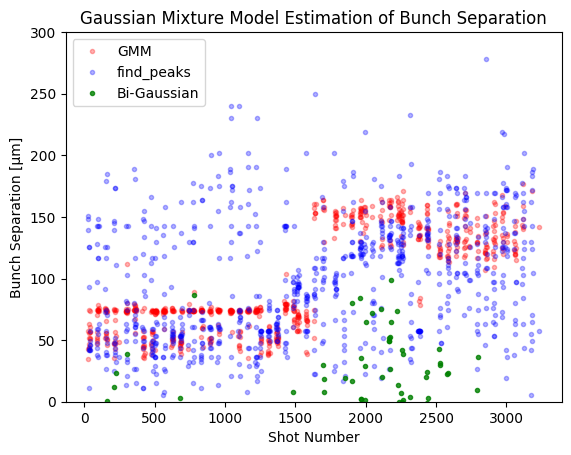

In [521]:
from sklearn.mixture import GaussianMixture

mean1 = []
mean2 = []
amp2 = []
sigma1 = []
sigma2 = [] 
weight1 = []
weight2 = []

for ij in range(len(plus_90_idx)):
    y = currentProfile_plus_90[ij, :]
    x = np.arange(len(y))
    cp = np.column_stack((x,y))
    if ij < 0.5*len(plus_90_idx):
        gm = GaussianMixture(n_components=4, random_state=0).fit(cp)
    
        m1 = gm.means_[0][0]
        m2 = gm.means_[1][0]
        s1 = np.sqrt(gm.covariances_[0][0][0])
        s2 = np.sqrt(gm.covariances_[1][0][0])
        w1 = gm.weights_[0]
        w2 = gm.weights_[1]
        mean1.append(m1)
        mean2.append(m2)
        amp2.append(currentProfile_plus_90[ij,int(m2)])
        sigma1.append(s1)
        sigma2.append(s2)
        weight1.append(w1)
        weight2.append(w2)
    else:
        gm = GaussianMixture(n_components=4, random_state=0).fit(cp) 
        
        m1 = gm.means_[0][0]
        m2 = gm.means_[3][0]
        s1 = np.sqrt(gm.covariances_[0][0][0])
        s2 = np.sqrt(gm.covariances_[3][0][0])
        w1 = gm.weights_[0]
        w2 = gm.weights_[3]
        mean1.append(m1)
        mean2.append(m2)
        amp2.append(currentProfile_plus_90[ij,int(m2)-10])
        sigma1.append(s1)
        sigma2.append(s2)
        weight1.append(w1)
        weight2.append(w2)


mean1 = np.array(mean1)
mean2 = np.array(mean2)
amp2 = np.array(amp2 )
sigma1 = np.array(sigma1)
sigma2 = np.array(sigma2)
weight1 = np.array(weight1)
weight2 = np.array(weight2)

goodShots = np.where(amp2 != 0)[0]
bunchSeparation_plus_90_fit = (mean1[goodShots] - mean2[goodShots]) * xtcalibrationfactor * 1e6 * 3e8 # in microns 
plt.plot(plus_90_idx[goodShots], bunchSeparation_plus_90_fit, 'r.', label = 'GMM', alpha = 0.3)
plt.plot(plus_90_idx, bunch_sep_plus_90_um, 'b.', label='find_peaks', alpha = 0.3)
plt.plot(plus_90_idx[goodShots_bigaus],biguas_fit, 'g.', label = 'Bi-Gaussian', alpha = 0.8 )
plt.title("Gaussian Mixture Model Estimation of Bunch Separation")
plt.xlabel("Shot Number")
plt.ylabel("Bunch Separation [μm]")
plt.ylim((0,300))
plt.legend()
plt.show()

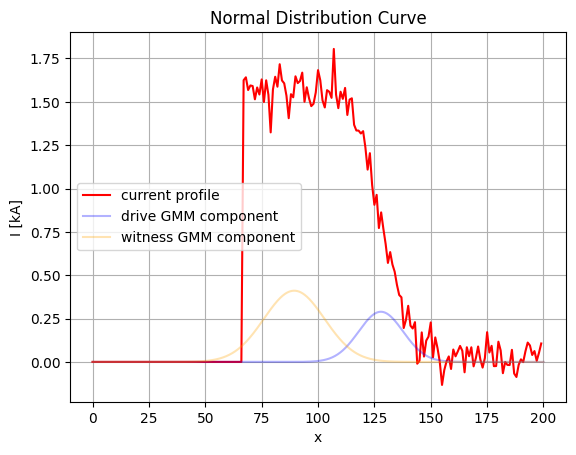

In [509]:
from scipy.stats import norm
i  = 300 # shot number

# Define parameters
mu1 = mean1[i]       # mean
s1 = sigma1[i]  # standard deviation
w1 = weight1[i]

mu2 = mean2[i]
s2 = sigma2[i]
w2 = weight2[i]

# Generate x values
x = np.linspace(0, 200, 1000)

# Compute normal distribution
gaussian1 = norm.pdf(x, mu1, s1)
gaussian2 = norm.pdf(x, mu2, s2)
y1 = gaussian1 * w1* np.max(currentProfile_plus_90[i,:]) / np.max(gaussian1)
y2 = gaussian2 * w2* np.max(currentProfile_plus_90[i,:]) / np.max(gaussian2)

# Plot
plt.plot(currentProfile_plus_90[i,:], 'red', label = "current profile")
plt.plot(x, y1, label=f'drive GMM component', color='blue', alpha = 0.3)
plt.plot(x, y2, label=f'witness GMM component', color='orange', alpha = 0.3)
plt.title('Normal Distribution Curve')
plt.xlabel('x')
plt.ylabel('I [kA]')
plt.grid(True)
plt.legend()
plt.show()

### Model Training

In [561]:
c = []

for n in range(predictor.shape[1]):
    X = np.array(predictor)[:,n]
    Y = bunchSep
    R = np.corrcoef(X, Y)
    c.append(R[0, 1])

c = np.array(c)
c = c[~np.isnan(c)]
absc = np.abs(c)
idx = np.argsort(absc)

sorted = predictor[:,idx[-10:]]
names = np.array(bsaVars)[idx[-10:]]
df = pd.DataFrame(sorted, columns = names)

/Users/siddhant/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/siddhant/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,TORO_LI20_2452_TMIT,BPMS_IN10_781_X,BPMS_LI14_891_TMIT,BPMS_LI20_3156_X,BPMS_LI11_265_X,BPMS_LI14_701_TMIT,TORO_LI14_890_TMIT,KLYS_LI10_21_FB_FAST_PACT,TORO_LI20_3163_TMIT,TCAV_LI20_2400_P
0,4.196042e+09,0.196268,9.767687e+09,-0.081509,0.046039,9.584921e+09,0.0,-22.272759,3.940105e+09,89.268547
1,4.232827e+09,0.185585,9.362915e+09,-0.019556,0.037183,9.195478e+09,0.0,-22.204740,3.807372e+09,90.154647
2,4.003444e+09,0.173966,9.297361e+09,-0.017053,0.050979,9.124391e+09,0.0,-22.297076,3.714296e+09,89.874269
3,4.115701e+09,0.176197,9.149530e+09,-0.075642,0.055333,8.975965e+09,0.0,-22.212725,3.803188e+09,89.540816
4,4.321825e+09,0.188792,9.725266e+09,-0.036622,0.055838,9.554600e+09,0.0,-22.202729,4.039794e+09,90.157952
...,...,...,...,...,...,...,...,...,...,...
686,3.196397e+09,0.201396,9.495301e+09,0.041625,0.057632,9.323788e+09,0.0,-22.643190,2.884971e+09,89.852242
687,3.260238e+09,0.179352,9.109632e+09,-0.035154,0.025826,8.943986e+09,0.0,-22.703023,2.952822e+09,89.800693
688,3.184764e+09,0.185213,9.588612e+09,0.034952,0.039617,9.449384e+09,0.0,-22.736061,2.911407e+09,89.491262
689,3.489620e+09,0.190445,9.337261e+09,0.036604,0.071154,9.184108e+09,0.0,-22.874054,3.191853e+09,90.247990


In [576]:
# 20-best parameter fit (bsaScalar PVs + step number)
predictor = np.vstack((bsaScalarData[idx[-20:],:][:,plus_90_idx[goodShots]],steps[plus_90_idx[goodShots]])).T
bunchSep = bunchSeparation_plus_90_fit

nsims=predictor.shape[0]
X = predictor

# 80/20 train-test split
ntrain = int(np.round(nsims*0.8))
ntest = int(np.round(nsims*0.2))

idx = np.random.permutation(nsims)
idxtrain = idx[0:ntrain]
idxtest = idx[ntrain:ntrain+ntest]

bs_scaled = bunchSep/np.max(bunchSep)
bs_train_scaled = bs_scaled[idxtrain]
bs_test_scaled = bs_scaled[idxtest] 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(predictor)
x_train_scaled = x_scaled[idxtrain]
x_test_scaled = x_scaled[idxtest]

IndexError: index 353 is out of bounds for axis 0 with size 130

In [555]:
# 2-parameter fit (bc14BLEN + step number)
predictor = np.vstack((bc14BLEN[0][plus_90_idx[goodShots]],steps[plus_90_idx[goodShots]])).T
bunchSep = bunchSeparation_plus_90_fit

nsims=sorted.shape[0]
X = sorted

ntrain = int(np.round(nsims*0.8))
ntest = int(np.round(nsims*0.2))

idx = np.random.permutation(nsims)
idxtrain = idx[0:ntrain]
idxtest = idx[ntrain:ntrain+ntest]

bs_scaled = bunchSep/np.max(bunchSep)
bs_train_scaled = bs_scaled[idxtrain]
bs_test_scaled = bs_scaled[idxtest] 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(predictor)
x_train_scaled = x_scaled[idxtrain]
x_test_scaled = x_scaled[idxtest]

Elapsed time [mins] = 0.1 
Score on training set = 81.243  %
Score on test set = 81.985 %


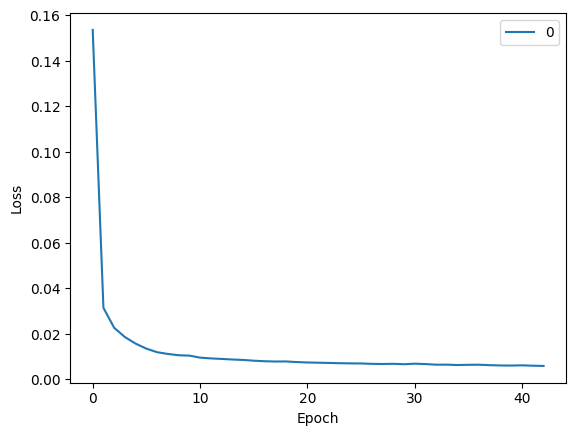

In [575]:
import sklearn.neural_network as nn
import time
import pandas as pd 

nn_model_curprof = nn.MLPRegressor(
    activation = 'relu',
    alpha = 1.0e-4,
    batch_size = 24,
    tol = 1e-4,# default 1e-4
#    hidden_layer_sizes = (500,200,100),
#    hidden_layer_sizes = (1000,500,500),
    hidden_layer_sizes = (1000, 500,500),#98% accuracy 5e-5 learning rate
    solver = 'adam',
    learning_rate = 'adaptive',# Only for sgd solver
    learning_rate_init = 5.0e-5,
    max_iter = 5000,
    beta_1 = 0.9,beta_2=0.999,# Only for adam solver
    shuffle = True,
    early_stopping = True,
    validation_fraction = 0.2,
    verbose = False,
    momentum = 0.7,# Only used for sgd solver
    warm_start = False,
    random_state = None
)
t0 = time.time()
# Fit the nn model on the training set
nn_model_curprof.fit(x_train_scaled,bs_train_scaled)
elapsed = time.time() - t0
print("Elapsed time [mins] = {:.1f} ".format(elapsed/60))
# Predict on training and validation set
predict_Iz_train = nn_model_curprof.predict(x_train_scaled)
predict_Iz_test = nn_model_curprof.predict(x_test_scaled)
#%% Print results and plot score
print("Score on training set = {0:.3f} ".format(nn_model_curprof.score(x_train_scaled,bs_train_scaled)*100),"%")
print("Score on test set = {0:.3f}".format(nn_model_curprof.score(x_test_scaled,bs_test_scaled) * 100),"%")
# print("Train RMSE:", np.sqrt(np.mean((Iz_train_scaled - nn_model_curprof.predict(X_train_scaled))**2)))
# print("Test RMSE:", np.sqrt(np.mean((Iz_test_scaled - nn_model_curprof.predict(X_test_scaled))**2)))
if nn_model_curprof.solver == 'adam':
    pd.DataFrame(nn_model_curprof.loss_curve_).plot()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()  

In [573]:
import joblib
joblib_file = 'model/MLP_E338_12710_21param.pkl'  
joblib.dump(nn_model_curprof, joblib_file)

['model/MLP_E338_12710_21param.pkl']

Test score: 84.975 %


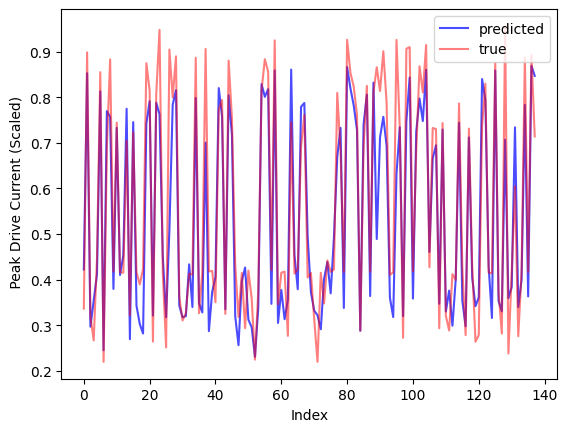

In [572]:
score = nn_model_curprof.score(x_test_scaled,bs_test_scaled)  
print("Test score: {0:.3f} %".format(100 * score)) 

plt.plot(nn_model_curprof.predict(x_test_scaled), 'b-', alpha = 0.7, label = 'predicted')
plt.plot(bs_test_scaled, 'r-', alpha = 0.5, label = 'true')
plt.ylabel(" Bunch Separation (Scaled)")
plt.xlabel("Index")
plt.legend(loc = 'upper right')
plt.show()